## 통계 기반 기법 개선하기

## PMI : 점별 상호 정보량(Pointwise Mutual Information), log 함수

### PPMI(Positive PMI) : 양의 상호 정보량,  PPMI(x,y) = max(0,PMI(x,y))

In [1]:
from mynlp import preprocess,create_co_matrix,cos_similarity,most_similar
import numpy as np


you
say
goodbye
and
i
say
hello
.
[0 1 2 3 4 1 5 6]
[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
[0 1 2 3 4 1 5 6]
{'i': 0, 'like': 1, 'apple': 2, 'and': 3, 'you': 4, 'banana': 5, '.': 6}
[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
0.7071067691154799
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
[0 1 0 1 0 0 0]
[0 1 0 0 0 0 1]
0.49999999292893216

[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [2]:
text = 'You say goodbye and I say hello.' 
corpus, word_to_id,id_to_word = preprocess(text)
print(corpus)     # 8 개
print(word_to_id) # 7 개
vocab_size = len(word_to_id)   
C = create_co_matrix(corpus,vocab_size)
print('동시발생행렬:\n',C)
C.shape  # (7,7)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
동시발생행렬:
 [[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


(7, 7)

In [3]:
M = np.zeros_like(C,dtype=np.float32) # (7,7)

N = np.sum(C)        # 14 , 동시발생행렬 요소전체의 합 
print(N)
S = np.sum(C,axis=0) # 동시발생행렬 요소의 수직 방향 합
print(S)  # [1 4 2 2 2 2 1]
print('동시발생행렬:\n',C)
total = C.shape[0] * C.shape[1] #  49, 동시발생행렬 요소의 총갯수

for i in range(C.shape[0]): # 7회
    for j in range(C.shape[1]) : # 7회
        # C[i,j] : 동시발생행렬의 요소한개의 값, 비교하려는 두 단어의 동시발생횟수
        # S[0] : 동시발생행렬에서 열의 'you' 단어의 동시 발생횟수
        # S[i] : 동시발생행렬에서 열의 한 단어의 동시 발생횟수 , 비교하려는 두단어 중 하나 ,x
        # S[j] : 동시발생행렬에서 열 한 단어에 대해 비교하려는 나머지 단어들의 동시 발생횟수
        # print(i,j,C[i,j])
        # print('S[%d]:'%i,S[i],'S[%d]:'%j,S[j])
        
        pmi = np.log2(C[i,j]*N /(S[i]*S[j]) + 1e-8 )
        M[i,j] = max(0,pmi) 
print('PPMI:\n',M)  # PPMI 행렬로 변환

14
[1 4 2 2 2 2 1]
동시발생행렬:
 [[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
PPMI:
 [[0.        1.8073549 0.        0.        0.        0.        0.       ]
 [1.8073549 0.        0.8073549 0.        0.8073549 0.8073549 0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.        1.8073549 0.        1.8073549 0.        0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.8073549 0.        0.        0.        0.        2.807355 ]
 [0.        0.        0.        0.        0.        2.807355  0.       ]]


In [4]:
# PPMI 행렬 변환 함수 구현 
def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[i]*S[j]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:  # total이 100 보다 작으면 오류!!
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [5]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)
print(W)  # 동시발생행렬보다 좀더 나은 확률에 기반한 PPMI행렬로 변환되었다

[[0.        1.8073549 0.        0.        0.        0.        0.       ]
 [1.8073549 0.        0.8073549 0.        0.8073549 0.8073549 0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.        1.8073549 0.        1.8073549 0.        0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.8073549 0.        0.        0.        0.        2.807355 ]
 [0.        0.        0.        0.        0.        2.807355  0.       ]]


### SVD(Singular Value Decomposition, 특잇값분해) 에 의한 차원의 축소

#### 차원 축소 알고리즘 정리
- PCA(Principal Component Analysis,주성분 분석) : 데이터의 분산(variance)을 최대한 보존하면서 서로 직교하는 새 기저(축)를 찾아, 고차원 공간의 표본들을 선형 연관성이 없는 저차원 공간으로 변환하는 기법, 정방행렬인 공분산행렬(covariance matrix)을 고유벡터(eigenvector)로 분해한다

 https://ratsgo.github.io/machine%20learning/2017/04/24/PCA/ 
<br>

- SVD(Singular Value Decomposition, 특잇값분해) : 임의의 행렬을 세 행렬의 곱으로 분해

$$ X=USV^T $$
      
   https://angeloyeo.github.io/2019/08/01/SVD.html
  
   https://darkpgmr.tistory.com/106 

[노트북문서화작업]
http://www.onemathematicalcat.org/MathJaxDocumentation/MathJaxKorean/TeXSyntax_ko.html

In [6]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)
print(W)  # (7,7)

[[0.        1.8073549 0.        0.        0.        0.        0.       ]
 [1.8073549 0.        0.8073549 0.        0.8073549 0.8073549 0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.        1.8073549 0.        1.8073549 0.        0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.8073549 0.        0.        0.        0.        2.807355 ]
 [0.        0.        0.        0.        0.        2.807355  0.       ]]


In [7]:
# SVD
U, S, V = np.linalg.svd(W)  #  PPMI 행렬 W을 밀집벡터 U로 변환

np.set_printoptions(precision=2)
print(U)

[[-3.41e-01 -1.11e-16 -3.89e-16 -1.21e-01  0.00e+00  9.32e-01  2.23e-16]
 [ 0.00e+00 -5.98e-01  1.80e-01  0.00e+00 -7.81e-01  0.00e+00  0.00e+00]
 [-4.36e-01 -4.24e-17 -2.17e-16 -5.09e-01 -1.77e-17 -2.25e-01 -7.07e-01]
 [-2.61e-16 -4.98e-01  6.80e-01 -6.57e-17  5.38e-01  9.95e-17  1.20e-17]
 [-4.36e-01 -3.23e-17 -1.65e-16 -5.09e-01 -1.35e-17 -2.25e-01  7.07e-01]
 [-7.09e-01 -3.23e-17 -1.65e-16  6.84e-01 -1.35e-17 -1.71e-01  5.89e-17]
 [ 3.06e-16 -6.28e-01 -7.10e-01  8.85e-17  3.17e-01 -2.85e-16 -1.55e-17]]


In [8]:
# 차원을 줄이려면 처음 2개의 요소를 꺼내면 된다
print(U[:,:2])  # (7,7)  --> (7,2)로 축소됨

[[-3.41e-01 -1.11e-16]
 [ 0.00e+00 -5.98e-01]
 [-4.36e-01 -4.24e-17]
 [-2.61e-16 -4.98e-01]
 [-4.36e-01 -3.23e-17]
 [-7.09e-01 -3.23e-17]
 [ 3.06e-16 -6.28e-01]]


{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
[('you', 0), ('say', 1), ('goodbye', 2), ('and', 3), ('i', 4), ('hello', 5), ('.', 6)]
you 0
say 1
goodbye 2
and 3
i 4
hello 5
. 6


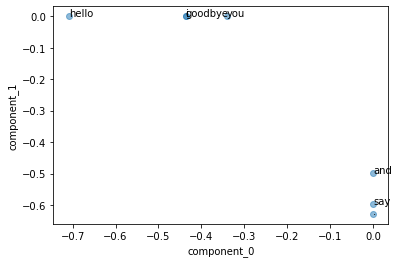

In [9]:
# 시각화
import matplotlib.pyplot as plt
print(word_to_id)
print(list(word_to_id.items()))
# plt.figure(figsize=(15,5))

for word, word_id in word_to_id.items(): # 7 회
    print(word,word_id)
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5) # x축이 차원 축소된 값의 0번 컬럼, y축이 차원 축소된 값의 1번 컬럼
plt.xlabel('component_0')
plt.ylabel('component_1')
plt.show()

# ('goodbye', 2) : [-4.363e-01 -4.241e-17]
#     ('i', 4)   : [-4.363e-01 -3.229e-17] , 두 개의 좌표값이 거의 동일하여 그래프에 i가 안보임

# 'goodbye'와 'hello', 'you'와 'i' 가 비교적 가까이 있음, 말뭉치 데이터셋이 아주 적어서 신뢰할 수 없음

### PTB 데이터셋  : Pen Treebank 말뭉치 , word2vec의 발명자 토마스미콜로프의 웹에 게시
 https://raw.githubusercontent.com/tomsercu/lstm/master/data/ptb.train.txt

In [10]:
from dataset import ptb

window_size = 2
wordvec_size = 100  # 축소할 차원 수

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print(vocab_size)  # 10000
print(len(corpus)) # 929589
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus,vocab_size,window_size)
print(C.shape)  # (10000, 10000)
C

10000
929589
동시발생 수 계산 ...
(10000, 10000)


array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
print('PPMI 계산 ....')
W = ppmi(C,verbose=True)

PPMI 계산 ....


C:\ProgramData\Anaconda3\envs\tf20\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\envs\tf20\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log2
  # This is added back by InteractiveShellApp.init_path()


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료


In [12]:
print(W.shape) #  (10000, 10000)
W

(10000, 10000)


array([[ 0.  , 19.24, 18.83, ...,  0.  ,  0.  ,  0.  ],
       [19.24,  0.  , 18.24, ...,  0.  ,  0.  ,  0.  ],
       [18.83, 18.24,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]], dtype=float32)

In [13]:
# SVD 사용 차원 축소
print('calculating SVD ...')

# truncated SVD : 속도가 빠르다
from sklearn.utils.extmath import randomized_svd

U,S,V = randomized_svd(W,n_components=wordvec_size, n_iter=5,random_state=None)

# numpy : 속도가 느리다
# U,S,V = np.linalg.svd(W)

print(U.shape)
word_vecs = U[:,:wordvec_size]
print(word_vecs.shape)  # (1000,100)
word_vecs

calculating SVD ...
(10000, 100)
(10000, 100)


array([[ 2.78e-10, -3.03e-07,  3.66e-07, ...,  2.29e-05, -1.00e-04,
        -7.29e-05],
       [-2.19e-11,  5.50e-09,  1.46e-07, ...,  5.27e-05, -1.47e-04,
        -1.03e-04],
       [-1.58e-12,  6.46e-09, -9.91e-09, ...,  8.92e-05, -1.92e-04,
        -1.46e-04],
       ...,
       [ 4.43e-03, -6.48e-03,  1.15e-02, ..., -2.78e-03,  3.51e-04,
         3.60e-03],
       [ 2.46e-03, -4.92e-03,  8.03e-03, ...,  1.56e-03, -1.03e-04,
         2.46e-03],
       [ 3.89e-03, -7.84e-03,  8.08e-03, ...,  7.22e-03,  5.81e-03,
         1.47e-03]], dtype=float32)

In [14]:
most_similar('say',word_to_id,id_to_word,word_vecs,top=5)


[query] say
 believe: 0.5996800661087036
 argue: 0.5481706857681274
 contend: 0.5095321536064148
 agree: 0.4971768260002136
 predict: 0.47779467701911926


In [15]:
most_similar('i',word_to_id,id_to_word,word_vecs,top=5)


[query] i
 'm: 0.6933141350746155
 you: 0.6864959001541138
 we: 0.6660029888153076
 've: 0.5654681921005249
 'd: 0.5246800184249878


In [16]:
most_similar('and',word_to_id,id_to_word,word_vecs,top=5)
# <unk> : unknown , 희소한 단어를 미리 치환해 놓음
# <eos> : end of sentence


[query] and
 <unk>: 0.6130483150482178
 <eos>: 0.5038152933120728
 for: 0.5014933347702026
 in: 0.4837667644023895
 of: 0.419532835483551


In [17]:
most_similar('N',word_to_id,id_to_word,word_vecs,top=5)
# N : 숫자는 모두 'N'으로 미리 치환 해둠


[query] N
 $: 0.7113919258117676
 cents: 0.6762191653251648
 points: 0.6337192058563232
 million: 0.6327099204063416
 average: 0.6110080480575562


In [18]:
querys = ['you','year','car','toyota']
for query in querys:
    most_similar(query,word_to_id,id_to_word,word_vecs,top=5)


[query] you
 i: 0.6864959001541138
 we: 0.6401221752166748
 've: 0.5221856832504272
 me: 0.5216322541236877
 do: 0.5121699571609497

[query] year
 quarter: 0.6544153690338135
 month: 0.64052414894104
 last: 0.6329690217971802
 earlier: 0.6173602342605591
 fiscal: 0.605424702167511

[query] car
 auto: 0.6655802726745605
 vehicle: 0.5634891986846924
 corsica: 0.5184327960014343
 domestic: 0.511766791343689
 automobile: 0.4816218614578247

[query] toyota
 motor: 0.7316420078277588
 nissan: 0.6923678517341614
 honda: 0.6658532619476318
 motors: 0.6258261203765869
 lexus: 0.5888863801956177
